In [166]:
# Standard library imports
import os
import sys
import importlib
import numpy as np
import random
import cv2
from tqdm import tqdm

# Add project-specific paths
sys.path.append(os.path.join(os.getcwd(), 'common'))

# Import custom modules
import embedding
import detection
import grt
import attacks
import test_utility
import utility
# Reload module for updates
importlib.reload(grt)

importlib.reload(detection)
importlib.reload(attacks)
importlib.reload(embedding)
importlib.reload(test_utility)

<module 'test_utility' from '/home/make/multimedia/multimedia-data-security/common/test_utility.py'>

## Test 1


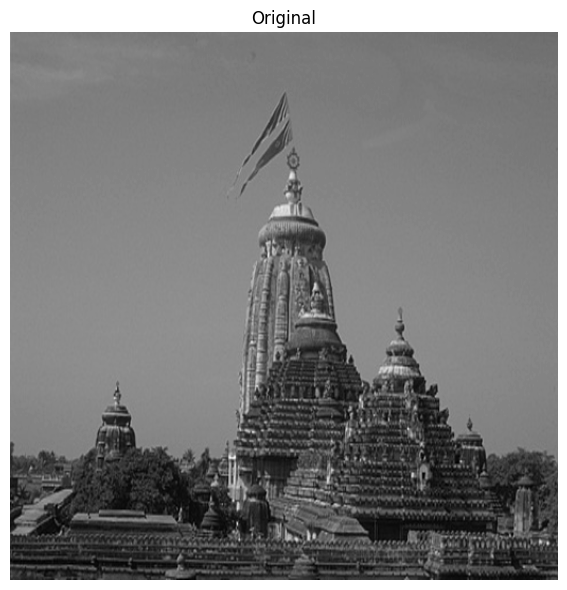

meanw psnr after embedding  66.84437995315689


Applying attacks: 100%|██████████| 9/9 [02:27<00:00, 16.36s/it, image=0, attack=gauss_edge, wpsnr=52.9, detected=0, param={'sigma': 0.6000000000000001, 'edge_func': 0}]

mean max attacked wpsnr  55.076652280516136
estimate points for invisibility + robusteness  6 0  total points = 6


In [167]:
total_history,total_succesfull_attacks,points =  test_utility.test_pipelines(
    alpha =0.48, 
    max_layer=1, 
    num_images=1)


In [168]:
for succ in total_succesfull_attacks:
   for s in succ:
       print("succesfull attack",s["attack"]," on image ", s['images'], " with wpsnr ", s['wpsnr'])

succesfull attack AWGN  on image  0  with wpsnr  37.267058602767705
succesfull attack Blur  on image  0  with wpsnr  55.076652280516136
succesfull attack Median  on image  0  with wpsnr  45.69927340699859
succesfull attack JPEG Compression  on image  0  with wpsnr  52.94833382414702
succesfull attack gauss_edge  on image  0  with wpsnr  52.929984603674036


In [163]:
for h in total_history:
    for i in h:
        print("history",i["attack"]," on image ", i['images'], " with wpsnr ", i['wpsnr'])

history AWGN  on image  0  with wpsnr  37.40813237685287
history AWGN  on image  0  with wpsnr  35.43536803011083
history AWGN  on image  0  with wpsnr  33.89094899337641
history AWGN  on image  0  with wpsnr  32.54152321003729
history AWGN  on image  0  with wpsnr  31.358409888562107
history AWGN  on image  0  with wpsnr  30.27891642642672
history AWGN  on image  0  with wpsnr  29.355784027974913
history AWGN  on image  0  with wpsnr  28.59034591637144
history AWGN  on image  0  with wpsnr  27.810796595310126
history AWGN  on image  0  with wpsnr  26.999941026530323
history AWGN  on image  0  with wpsnr  26.369371761545153
history AWGN  on image  0  with wpsnr  25.756579455129767
history AWGN  on image  0  with wpsnr  25.248249235981262
history AWGN  on image  0  with wpsnr  24.70305005623372
history AWGN  on image  0  with wpsnr  24.233557779980334
history AWGN  on image  0  with wpsnr  23.811591644244476
history AWGN  on image  0  with wpsnr  23.316956682157116
history Blur  on imag

### Test 2

In [ ]:
total_history,total_succesfull_attacks,points =  utility.test_pipelines(
    alpha =1, 
    max_layer=2, 
    num_images=3,
    embedding_fn=embedding.embedding,
    attacks_list=attacks.attack_incremental_paramters,
    detection_fn=detection.detection)



### Test 3

In [ ]:
total_history,total_succesfull_attacks,points =  utility.test_pipelines(
    alpha =2, 
    max_layer=2, 
    num_images=3,
    embedding_fn=embedding.embedding,
    attacks_list=attacks.attack_incremental_paramters,
    detection_fn=detection.detection)

### Test 4

In [ ]:
total_history,total_succesfull_attacks,points =  utility.test_pipelines(
    alpha =3, 
    max_layer=2, 
    num_images=3,
    embedding_fn=embedding.embedding,
    attacks_list=attacks.attack_incremental_paramters,
    detection_fn=detection.detection)